# Year of publication

### Primary research questions:

The notebook partly answers the following research question:

2. How is sharing affected by FOSS, Covid-19, publication type and year of publication?

> Specifically we look at the number of shared models split into general health and Covid-19 subgroups.  We also analyse how the number of shared models as a proportion of the literature.

## 1. Imports 

### 1.1. Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# set up plot style as ggplot
plt.style.use('ggplot')

## 1.2 Imports from preprocessing module

In [2]:
# function for loading full dataset
from preprocessing import load_clean_dataset

## 2. Constants

In [3]:
FILE_NAME = 'https://raw.githubusercontent.com/TomMonks/' \
    + 'des_sharing_lit_review/main/data/share_sim_data_extract.zip'

RG_LABEL = 'reporting_guidelines_mention'
NONE = 'None'
WIDTH = 0.5

## 3. Functions

### 3.1. Functions to create summary statistics

Two functions are used together in order to generate the high level results by year. 

* `high_level_metrics` - takes a subgroup of the dataset and generates summary statistics and counts
* `analysis_by_year` - loop through the years passing each to `high_levle_metrics` and concatenates datasets at the end.

In [4]:
def high_level_metrics(df, name='None'):
    '''A simple high level summary of the review.
    
    Returns a dict containing simple high level counts
    and percentages in the data#
    
    Params:
    -------
    df: pd.DataFrame 
        A cleaned dataset.  Could be overall or subgroups/categories
        
    Returns:
    --------
        dict 
    '''
    results = {}
    included = df[df['study_included'] == 1]
    available = included[included['model_code_available'] == 1]
    results['n_included'] = len(included[included['study_included'] == 1])
    results['n_foss'] = len(included[included['foss_sim'] == '1'])
    results['n_covid'] = len(included[included['covid'] == 1])
    results['n_avail'] = len(included[included['model_code_available'] == 1])
    results['n_foss_avail'] = len(available[available['foss_sim'] == '1'])
    results['n_covid_avail'] = len(available[available['covid'] == 1])
    results['per_foss'] = results['n_foss'] / results['n_included']
    results['per_covid'] = results['n_covid'] / results['n_included']
    results['per_avail'] = results['n_avail'] / results['n_included']
    results['per_foss_avail'] = results['n_foss_avail'] / results['n_foss']
    
    # fix for 2019 as `n_covid` = 0
    if results['n_covid'] > 0:
        results['per_covid_avail'] = \
            results['n_covid_avail'] / results['n_covid']
    else:
        results['n_covid_avail'] = 0.0
    results['reporting_guide'] = \
        len(included[included['reporting_guidelines_mention'] != 'None'])
    results['per_reporting_guide'] = \
        results['reporting_guide'] / results['n_included']
    return pd.Series(results, name=name)

In [5]:
def analysis_by_year(df_clean, decimals=4):
    '''
    Conducts a high level analysis by year of publication
    2019-2022
    
    Params:
    -------
    df_clean: pd.DataFrame
        Assumes a cleaned version of the dataset.
    
    Returns: 
    -------
    pd.DataFrame
        Containing the result summary
        
    '''
    overall_results = high_level_metrics(df_clean, 'overall')
    year_results = []
    years = df_clean['pub_yr'].unique().tolist()
    for year in years:
        subset = df_clean[df_clean['pub_yr'] == year]
        year_results.append(high_level_metrics(subset, name=str(year)))
    year_results = [overall_results] + year_results
    year_results = pd.DataFrame(year_results).T.round(decimals)
    return year_results[sorted(year_results.columns.tolist())]

### 3.2 Functions to plot results

* `get_subgroups_as_dataframes`. Creates simpler to use DataFrame containing annual summaries of shared and non-shared models.  These are split into non-covid and covid subgroups.
* `plot_sharing_by_year` - plot with 2 subfigures. The top subfigure is a stacked barchart of general health models + covid-19 models that have been shared by year of publication.  The lower subfigure presents yearly results as a percentage of total papers included in the study.

In [6]:
def get_subgroups_as_dataframes(yr_summary):
    '''
    Create seperate subgroups from the yr_summary table
    and return as independent DataFrame objects.  The overall column
    is dropped and only annual figures are included.
    
    Makes assumptions about the naming of colunms in yr_summary.
    
    1. Non covid models shared
    2. Covid models shared
    3. Covid models not shared
    4. Non covid models shared.
    
    Params:
    -------
    yr_summary: pd.DataFrame
        Dataframe containing summary of metrics by publication year
        
    Returns:
    -------
    tuple
    non-covid shared, covid shared, covid not shared, non covid not shared.
    '''
    
    # non covid shared models 
    non_covid_shared = yr_summary.T['n_avail'] \
        - yr_summary.T['n_covid_avail']
    
    # covid shared models
    covid_shared = yr_summary.T['n_covid_avail']
    
    # Covid models not shared
    covid_not_shared = yr_summary.T['n_covid'] \
        - yr_summary.T['n_covid_avail']
    
    # non covid not shared
    non_covid_not_shared = yr_summary.T['n_included'] \
        - yr_summary.T['n_avail'] - yr_summary.T['n_covid']
    
    # trim the overall column
    return non_covid_shared[:-1], covid_shared[:-1], covid_not_shared[:-1], \
           non_covid_not_shared[:-1]

In [7]:
def plot_sharing_by_year(n_general_models, n_covid_models, 
                         per_models, xlabels, width=WIDTH, grid=True,
                         figsize=(6, 5)):
    '''
    Plot the number of models shared by year of publication (in citation).
    
    In this function we split models into two subgroups: covid and non-covid
    Non-covid models are refered to as 'general health models'
    
    The function creates a figure with two subplots.  
    
    Subplot 1: A stacked barchart of general health models (non covid) 
    + covid-19 models that have been shared by year of publication.  A legend is
    provided to distinguish between general and covid models.
    
    Subplot 2: A bar chart expressing the total number of shared models as a 
    percentage of the number of included studies.
    
    Params:
    -------
    n_general_models: pd.DataFrame
        Count of non covid-19 models that have been shared by year of pub.
        
    n_covid_models: pd.DataFrame
         Count of covid-19 models that have been shared by year of pub.
         
    per_models: pd.DataFrame
        Percent of total studies included that have been shared by year of pub.
        
    xlabels: list:
        The years that represent the x-axis
        
    width: float, optional (default=WIDTH)
        A parameter to manipulated the width of the bars (applies to both plots)
        
    grid: bool, optional (default=True)
        Display grid lines (applies to both subplots)
        
    figsize: tuple(int, int), optional (default=(6,5)
        The size of the figure.
        
    Returns:
    --------
    fig, ax

    '''
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
    
    # plot one: stacked bar chart.  general health + covid models
    y1 = ax1.bar(xlabels, n_general_models, 
                label='General Health', width=width)

    y2 = ax1.bar(xlabels, n_covid_models,
               label='Covid-19', bottom=n_general_models, width=width)

    _ = ax1.set_ylabel('Shared Models')
    _ = ax1.legend(ncols=1, loc='upper left', fontsize=8)
    
    # force integer values on y axis
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
        
    ax1.bar_label(y2)

    # set size of x, y ticks
    ax1.tick_params(axis='both', labelsize=9)
    ax2.tick_params(axis='both', labelsize=9)

    # plot 2: percentage available by year
    _ = ax2.bar(xlabels, per_models, label='All models', 
                width=width, color='green')

    _ = ax2.set_ylabel('Percent of literature')
    
    return fig, (ax1, ax2)

In [8]:
def plot_all_subgroups_by_year(non_covid_shared, covid_shared, 
                               per_models, non_covid_not_shared, 
                               covid_not_shared,
                               xlabels, width=WIDTH, grid=True,
                               figsize=(6, 6)):
    '''
    Plot the number of models across subgroups by year of publication (in citation).
    
    In this function we split models into four subgroups: covid and non-covid 
    and shared and non-shared.
    
    Non-covid models are refered to as 'general health models'
    
    The function creates a figure with two subplots.  
    
    Subplot 1: A stacked barchart of unshared general health models (non covid)
    + unshared covid-19 + shared non-covid + shared covid that have been shared 
    by year of publication.  
    
    A legend is provided to distinguish between the four subgroups
    
    Subplot 2: A bar chart expressing the total number of shared models as a 
    percentage of the number of included studies.
    
    Params:
    -------
    non_covid_shared: pd.DataFrame
        Count of non covid-19 models that have been shared by year of pub.
        
    covid_shared: pd.DataFrame
         Count of covid-19 models that have been shared by year of pub.
         
    non_covid_not_shared: pd.DataFrame
        Count of non covid-19 models that have NOT been shared by year of pub.
        
    covid_not_shared: pd.DataFrame
         Count of covid-19 models that have NOT been shared by year of pub.
         
    per_models: pd.DataFrame
        Percent of total studies included that have been shared by year of pub.
        
    xlabels: list:
        The years that represent the x-axis
        
    width: float, optional (default=WIDTH)
        A parameter to manipulated the width of the bars (applies to both plots)
        
    grid: bool, optional (default=True)
        Display grid lines (applies to both subplots)
        
    figsize: tuple(int, int), optional (default=(6,5)
        The size of the figure.
        
    Returns:
    --------
    fig, ax

    '''
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
    
    # plot one: stacked bar chart.  general health + covid models
    y1 = ax1.bar(xlabels, non_covid_not_shared, 
                label='Closed General', width=width)

    y2 = ax1.bar(xlabels, covid_not_shared,
                 label='Closed Covid-19', bottom=non_covid_not_shared, 
                 width=width)
    
    y3 = ax1.bar(xlabels, non_covid_shared,
                 label='Open General', 
                 bottom=non_covid_not_shared+covid_not_shared, width=width)

    y4 = ax1.bar(xlabels, covid_shared,
                 label='Open Covid-19', 
                 bottom=non_covid_not_shared+covid_not_shared+
                 non_covid_shared, width=width)

    _ = ax1.set_ylabel('Models')
    
    _ = fig.legend(loc='upper left', ncol=2, bbox_to_anchor=(0.11, 1.0), 
                   fontsize=9)

    # include x, y grid 
    if grid:
        ax1.grid(ls='--', axis='y')
        ax2.grid(ls='--', axis='y')
        
    ax1.bar_label(y4)

    # set size of x, y ticks
    ax1.tick_params(axis='both', labelsize=9)
    ax2.tick_params(axis='both', labelsize=9)

    # plot 2: percentage available by year
    _ = ax2.bar(xlabels, per_models, label='All models', 
                width=width, color='green')

    _ = ax2.set_ylabel('Percent of literature')
    
    return fig, (ax1, ax2)

## 4. Read in data

In [9]:
clean = load_clean_dataset(FILE_NAME)

## 5. Results

### 5.1 Overall summary table

In [10]:
# overall
year_summary = analysis_by_year(clean)
year_summary

,2019,2020,2021,2022,overall
n_included,126.0000,135.0000,158.0000,145.0000,564.0000
n_foss,18.0000,21.0000,35.0000,27.0000,101.0000
n_covid,0.0000,9.0000,35.0000,25.0000,69.0000
n_avail,5.0000,14.0000,15.0000,13.0000,47.0000
n_foss_avail,5.0000,7.0000,10.0000,7.0000,29.0000
n_covid_avail,0.0000,4.0000,11.0000,2.0000,17.0000
per_foss,0.1429,0.1556,0.2215,0.1862,0.1791
per_covid,0.0000,0.0667,0.2215,0.1724,0.1223
per_avail,0.0397,0.1037,0.0949,0.0897,0.0833
per_foss_avail,0.2778,0.3333,0.2857,0.2593,0.2871


#### Average shared by year.

In [11]:
year_summary.loc['n_included'][:-1].mean()

141.0

In [12]:
year_summary.loc['n_covid'][1:-1].mean()

23.0

### 5.3. Sharing of models by year of publication

In [13]:
# Get the subgroups from the year by year results
non_covid_shared, covid_shared, covid_not_shared, \
           non_covid_not_shared = get_subgroups_as_dataframes(year_summary)

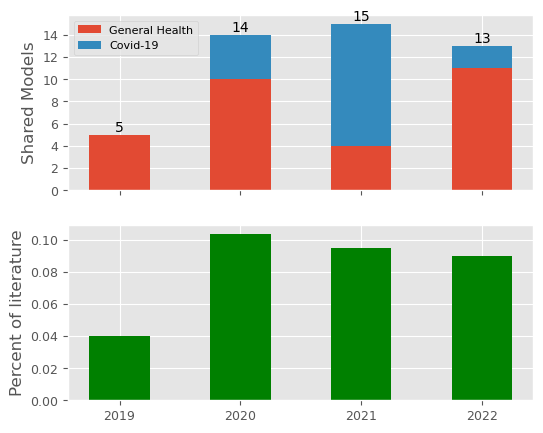

In [14]:
fig1, axs = plot_sharing_by_year(n_general_models=non_covid_shared,
                                 n_covid_models=covid_shared,
                                 per_models=year_summary.T['per_avail'][:-1],
                                 xlabels=year_summary.columns[:-1],
                                 grid=False)

In [15]:
# output the chart as .png for publication
fig1.savefig('fig2.png', dpi=300, bbox_inches='tight')

### 5.4 All sharing subgroups by year of publication.

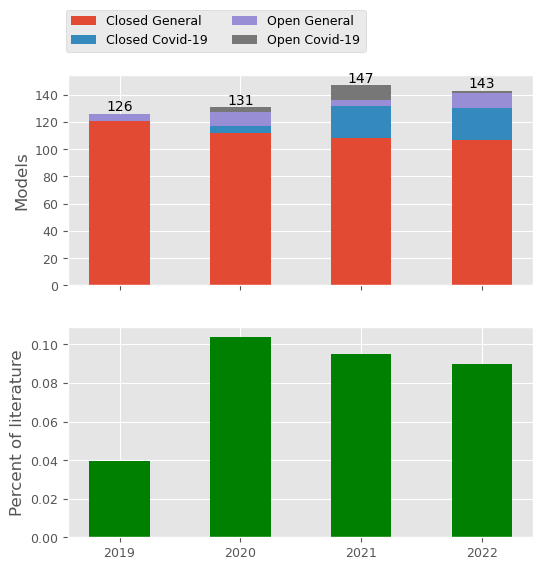

In [16]:
fig, axs = plot_all_subgroups_by_year(non_covid_shared=non_covid_shared,
                                      covid_shared=covid_shared,
                                      per_models=year_summary.T['per_avail'][:-1],
                                      non_covid_not_shared=non_covid_not_shared,
                                      covid_not_shared=covid_not_shared,
                                      xlabels=year_summary.columns[:-1],
                                      grid=False)